# 2.1 Transit light curve analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2023-2024 exercise 2

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 28.4.2024

## Initialisation

In [1]:
%matplotlib inline 

In [2]:
import math as mt
import pandas as pd
import warnings
import seaborn as sb

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, array, median, seterr, floor, percentile
from numpy.random import seed, permutation
from astropy.table import Table
from corner import corner

from pytransit import TransitLPF

seterr('ignore')
seed(0)

C:\Users\iriso\anaconda3\envs\TFRM\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\iriso\anaconda3\envs\TFRM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read in the data

First we need to read in the light curve stored in ``wasp-12b_181227_chromatic_k.fits``. The file has light curves for a single transit observed simultaneously in four passbands (g, r, i, and z_s), but we keep things simple and use only the r-band data. 

In our case, the photometry is saved as binary table extensions in the fits file, one extension per passband. To get the r-band data, we need to read the third HDU of the fits file (the first is the primary HDU, the second the first extension, etc.).

We start the same way as with the RV data and take a look at our data and try plotting it.

In [3]:
tb = Table.read('data/wasp-12b_181227_chromatic_k.fits', 2)
tb[:5]

time_bjd,flux,flux_rel,flux_trg,flux_ref,baseline,model
float64,float64,float64,float64,float64,float64,float64
2458480.557361179,1.0001350941062013,1.016282780690799,1.0234186998514527,1.0070215881802143,1.0161455054219737,1.0
2458480.558397079,1.0000222850175708,1.0167163747091499,1.0256873377854854,1.0088234667007323,1.0166937176717874,1.0
2458480.5587828704,0.999633046547194,1.0162828378132795,1.0244264276468822,1.0080131136044028,1.016655903207277,1.0
2458480.5594445122,1.0004227218395325,1.0169303171289636,1.0232086525273774,1.0061738108232814,1.016500620116942,1.0
2458480.5602084063,0.9981259684100012,1.0146302762017558,1.021813766379826,1.0070799091516973,1.0165352954577924,1.0


Now, we can assume the time data is stored in the ``time_bjd`` column and the flux the ``flux`` column. In general, if you'd see a file like this, you should check the file's documentation (if such exists) what column is what, or ask the person who created the file.

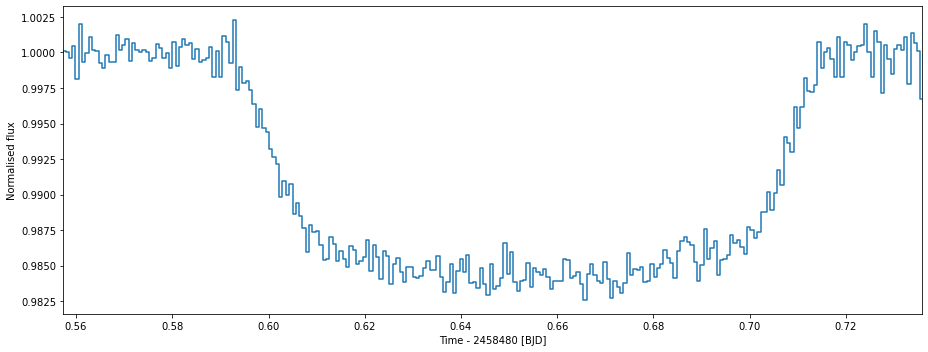

In [4]:
tref = floor(tb['time_bjd'].mean())
fig, ax = subplots(figsize=(13,5), sharey=True)
ax.plot(tb['time_bjd'] - tref, tb['flux'], drawstyle='steps-mid')
setp(ax, xlabel=f"Time - {tref:.0f} [BJD]", ylabel='Normalised flux', xlim=tb['time_bjd'][[0,-1]]-tref)
fig.tight_layout()

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

### Initialise the LPF and set the priors

In [5]:
lpf = TransitLPF('WASP-12b', 'r', tb['time_bjd'], tb['flux'])
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

In [6]:
lpf.set_prior('tc', 'NP', 2458480.65, 0.02)
lpf.set_prior('p', 'NP', 1.0914201, 1.1e-09)

In [7]:
lpf.ps

[  0 |G| tc             N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p              N(μ = 1.0914201, σ = 1.1e-09)            [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\iriso\anaconda3\envs\TFRM\lib\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


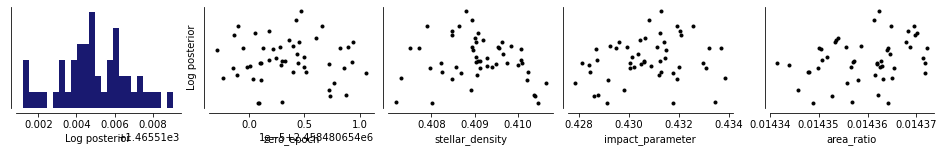

In [8]:
lpf.optimize_global(niter=500, npop=50)

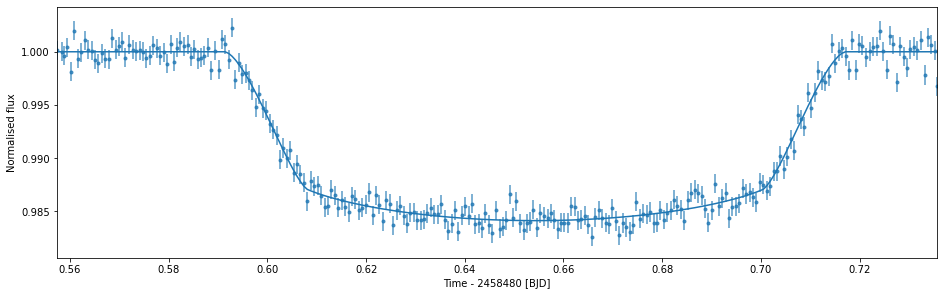

In [9]:
lpf.plot_light_curve();

In [10]:
lpf.sample_mcmc(5000, thin=20, repeats=2, label='MCMC sampling')

Run 2/2:  91%|█████████ | 4537/5000 [00:06<00:00, 687.52it/s]


MCMC sampling: 100%|██████████| 2/2 [00:13<00:00,  7.00s/it] 


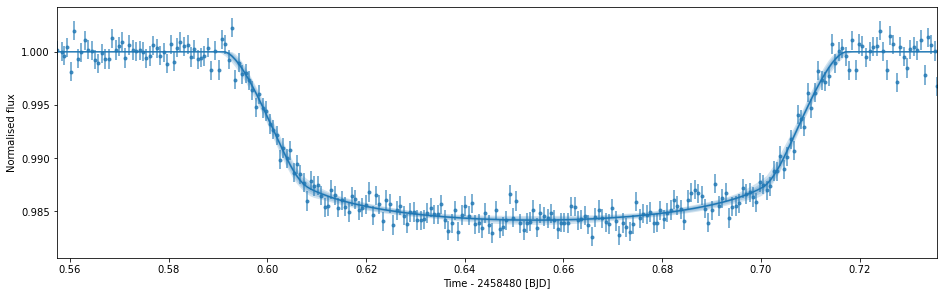

In [11]:
lpf.plot_light_curve('mc');

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

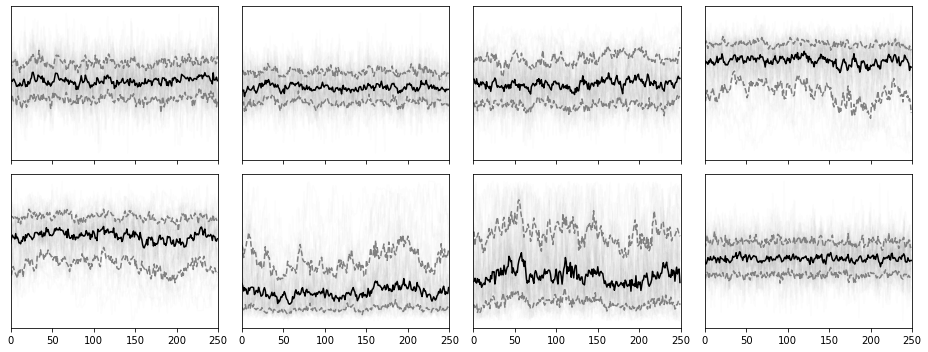

In [12]:
fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
[axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
setp(axs, yticks=[], xlim=[0,5000//20])
fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [13]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [14]:
flux_pr = lpf.flux_model(fc[permutation(fc.shape[0])[:1000]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

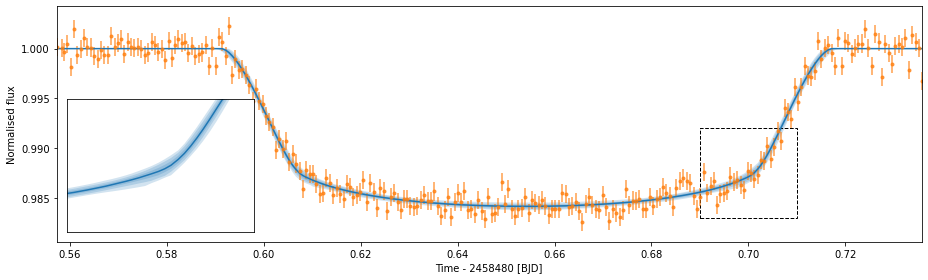

In [15]:
zx1,zx2,zy1,zy2 = 0.69,0.71, 0.983, 0.992
tref = floor(lpf.timea.min())
fig, ax = subplots(1,1, figsize=(13,4))
ax.errorbar(lpf.timea-tref, lpf.ofluxa, 10**mp[7], fmt='.', c='C1', alpha=0.75)
[ax.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
ax.plot(lpf.timea-tref, flux_pc[0], c='C0')
setp(ax, xlim=lpf.timea[[0,-1]]-tref, xlabel=f'Time - {tref:.0f} [BJD]', ylabel='Normalised flux')
fig.tight_layout()

az = fig.add_axes([0.075,0.18,0.20,0.46])
ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
[az.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
az.plot(lpf.timea-tref, flux_pc[0], c='C0');

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [16]:
pd.set_option('display.precision',4)
df = lpf.posterior_samples(derived_parameters=True)
df.describe()

,tc,p,rho,b,k2,q1_r,q2_r,wn_loge_0,k,a,inc,t14,t23
count,1.2500e+04,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000
mean,2.4585e+06,1.0914e+00,0.4302,0.3557,0.0140,0.2921,0.3683,-3.0425,0.1184,3.0011,1.4509,0.1258,0.0942
std,1.6149e-04,1.0910e-09,0.0350,0.1067,0.0004,0.1880,0.2421,0.0191,0.0018,0.0813,0.0383,0.0010,0.0025
min,2.4585e+06,1.0914e+00,0.3204,0.0004,0.0126,0.0478,0.0004,-3.1116,0.1122,2.7223,1.3571,0.1219,0.0870
25%,2.4585e+06,1.0914e+00,0.4044,0.2996,0.0137,0.1511,0.1753,-3.0559,0.1172,2.9420,1.4229,0.1251,0.0924
50%,2.4585e+06,1.0914e+00,0.4275,0.3821,0.0141,0.2382,0.3195,-3.0427,0.1187,2.9970,1.4429,0.1257,0.0939
75%,2.4585e+06,1.0914e+00,0.4554,0.4338,0.0143,0.3775,0.5275,-3.0297,0.1198,3.0610,1.4728,0.1264,0.0960
max,2.4585e+06,1.0914e+00,0.5378,0.5775,0.0151,0.9974,0.9997,-2.9571,0.1227,3.2354,1.5707,0.1295,0.1015


<AxesSubplot: >

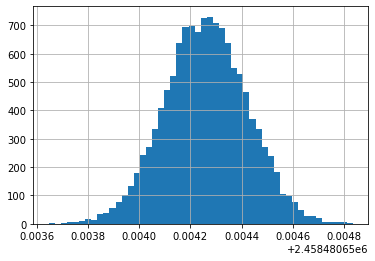

In [17]:
df.tc.hist(bins=50)

C:\Users\iriso\anaconda3\envs\TFRM\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\iriso\anaconda3\envs\TFRM\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\iriso\anaconda3\envs\TFRM\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\iriso\anaconda3\envs\TFRM\lib\site

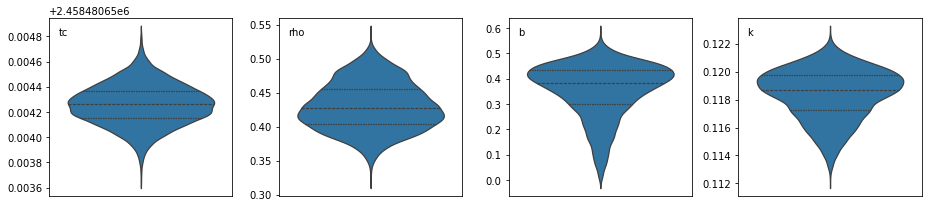

In [18]:
fig, axs = subplots(1,4, figsize=(13,3))
pars = 'tc rho b k'.split()
[sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
setp(axs, xticks=[], ylabel='')
fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

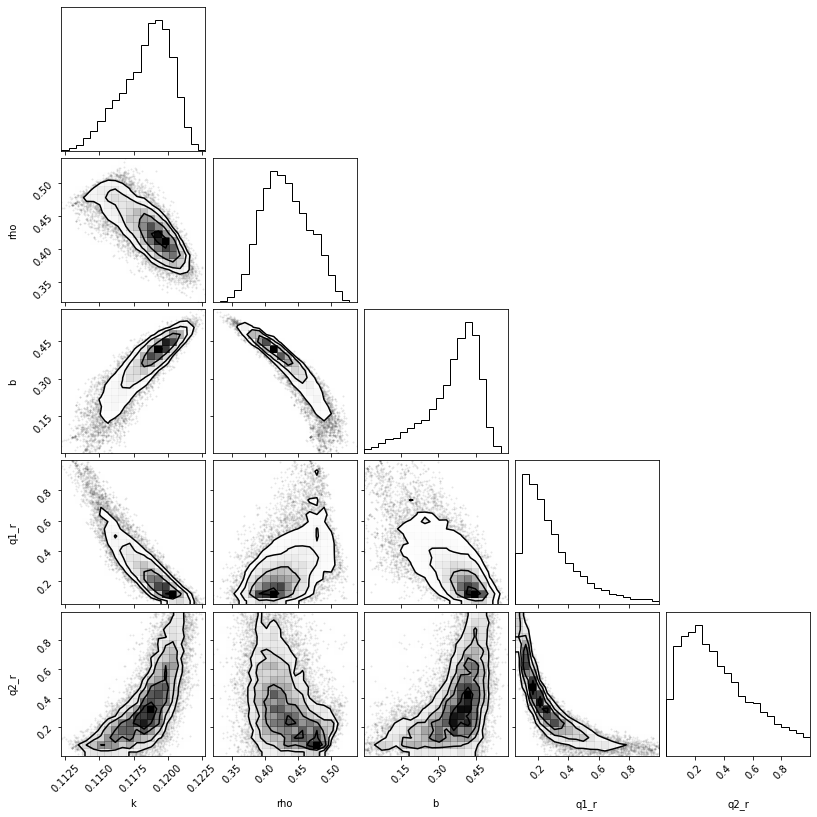

In [19]:
ccols = ['k', 'rho', 'b', 'q1_r', 'q2_r']
corner(df[ccols].values, labels=ccols);

### <span style="color:darkblue">Questions and exercises</span>

1. Estimate the radius of the planet using the planet-star radius ratio (k) and the stellar radius (that you need to find from somewhere) Give the answer in Jupiter radii.

$$k=\dfrac{R_p}{R_{\star}}\implies R_p=k R_{\star}\ .$$

From [Hebb et al. (2009)](https://iopscience.iop.org/article/10.1088/0004-637X/693/2/1920) we extract the radius of the host star: $R_{\star}=1.57\pm 0.07R_{\odot}$.

C:\Users\iriso\AppData\Local\Temp\ipykernel_20464\4284837326.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  k_mode = stats.mode(df['k'])[0]


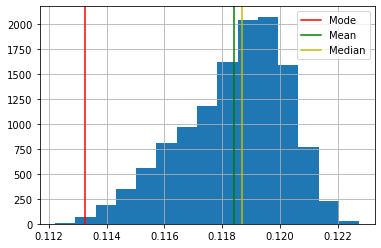

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

k_median = np.median(df['k'])
k_mean = np.mean(df['k'])
k_mode = stats.mode(df['k'])[0]

df.k.hist(bins=15)
plt.axvline(k_mode, c = 'r', label = 'Mode')
plt.axvline(k_mean, c = 'g', label = 'Mean')
plt.axvline(k_median, c = 'y', label = 'Median')
plt.legend()

We choose to do the calculations with the median value since it is the closer to the most populated value in the histogram.

In [66]:
import ephem

R_sun = ephem.sun_radius # in m
R_star = 1.57*R_sun
R_J = 0.10045*R_sun

R_p = k_median*R_star
R_std = df.describe()['k']['std']*R_star

print(R_p, '+/-', R_std, ' m = (', R_p/R_J, '+/-', R_std/R_J, ') R_J')

129523824.50428638 +/- 1965228.8040326023  m = ( 1.855303286352226 +/- 0.028149998446309627 ) R_J


We obtain $R_p\approx(1.86\pm 0.03)R_J$. From [Yee et al. (2019)](https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16) we extract that the value, also computed using the transit method, is $R_p\approx1.90R_J$

2. Compare the stellar density ($\rho$) estimated from the transit modelling to the theoretical stellar density for a WASP-12-like star.

C:\Users\iriso\AppData\Local\Temp\ipykernel_20464\1537189697.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  rho_mode = stats.mode(df['rho'])[0]


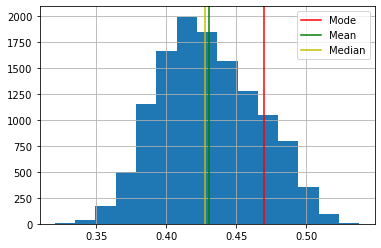

In [36]:
df.rho.hist(bins=15)

rho_median = np.median(df['rho'])
rho_mean = np.mean(df['rho'])
rho_mode = stats.mode(df['rho'])[0]

plt.axvline(rho_mode, c = 'r', label = 'Mode')
plt.axvline(rho_mean, c = 'g', label = 'Mean')
plt.axvline(rho_median, c = 'y', label = 'Median')
plt.legend()

We choose to do the calculations with the median value since it is the closer to the most populated value in the histogram.

In [54]:
print('Density computed with our transit analysis:', rho_median, '+/-', df.describe()['rho']['std'], ' g/cm^3.')

Density computed with our transit analysis: 0.4274964429587294 +/- 0.03496027785824863  g/cm^3.


We obtain a density of $\rho\approx 0.43\pm 0.03$ g/cm$^3$.

From [SIMBAD](https://simbad.u-strasbg.fr/simbad/sim-id?submit=display&bibdisplay=refsum&bibyear1=1850&bibyear2=2009&Ident=%404700112&Name=WASP-12) we know that the spectral type of WASP-12 is G0V. From [Wikipedia](https://en.wikipedia.org/wiki/G-type_main-sequence_star) we know that a G0V star has a typical mass and radius of $1.06M_{\odot}$	and $1.100R_{\odot}$. We compute its approximate typical density:

In [56]:
M_sun = 1.98847 * 10**33 # g
R_sun = ephem.sun_radius*100 # cm
G0V_M = 1.06*M_sun #g
G0V_R = 1.100*R_sun

G0V_dens = G0V_M*3/(4*np.pi *R_sun**3)
print('Density of a typical G0V star:', GOV_dens, 'g/cm^3.')

Density of a typical G0V star: 1.4989318416558906 g/cm^3.


And we compare both values:

In [58]:
print('Ratio between densities:', rho_median/G0V_dens)

Ratio between densities: 0.2852007216595441


Our value is less than a third of the expected value of a typical G0V star. However, from [Yee et al. (2019)](https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16) we extract a value of $0.46$ g/cm$^3$, which is compatible with the value we have computed. This difference between values might be due to the star being in a stage where it is leaving the Main Sequence. It is also worth noting that its orbit is decaying, so it may have a higher mass loss rate than expected.

3. From the plot above you can see that many of the parameters are correlated with each other. What does this mean in practice?

Since they are correlated we can compare the distributions we obtain for each one, as done in the plot, and by doing that narrow down the range of values each parameter may take as the region where the distribution of both parameters peaks. However, we find that these regions are quite large, from their plots we can see that some parameters are degenerated, so we know that we can not obtain a precise and true value for a third parameter computed using them.

Hence, this plots let us see the correlations between parameters, the values that have a higher probability of being the real physical values of the transit and the parameters that are degenerated. It is important to know the degeneracy of these values since they are a source of uncertainty.

---
<center>&copy;2024 Hannu Parviainen</center>